In [ ]:
!pip install lazypredict
!pip install shap
!pip install pycaret

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 483.6/483.6 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 15.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 9.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.4/46.4 kB 5.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparin

In [ ]:
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import SelectKBest, chi2
from sklearn import preprocessing
import pandas as pd
import os
from google.colab import drive
import time
from datetime import datetime
from collections import Counter
import numpy as np
from  sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.metrics import balanced_accuracy_score, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier
from lazypredict.Supervised import LazyClassifier
from sklearn.preprocessing import OneHotEncoder
from pycaret.classification import *

In [ ]:
drive.mount('/content/drive/')

os.chdir('/content/drive/MyDrive/CRISP-DM/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


#Loading

In [ ]:
df = pd.read_csv('RTA Dataset.csv')

In [ ]:
df.drop(["Casualty_class", "Sex_of_casualty", "Age_band_of_casualty", "Casualty_severity", "Work_of_casuality", "Fitness_of_casuality","Defect_of_vehicle",'Service_year_of_vehicle','Pedestrian_movement','Number_of_casualties'],axis=1,inplace=True)
df.replace([np.nan, 'Unknown','unknown'], None, inplace=True)

#Configuration

In [ ]:
# Impute missing values: 1/0
Set_IMV = 1

# Encoding: 1/0
Set_enc = 1

# Feature Selection methode: 0 - ALL, 1 - chi
Set_FS = 1

# Imbalance methode : 0 - None, 1 - wighted classes, 2 - Three binary classifiers, 3 - oversampling
Set_IM = 0

# Model : 0 - XGBoost, 1 - DecisionTreeClassifier, 2 - LGBMClassifier, 3 - Gradient Boosting, 4 - Random Forest
Set_model = 0

#Cleaning

In [ ]:
df['Time'] = pd.to_datetime(df['Time'], format='%H:%M:%S').dt.time
df['hour'] = df['Time'].apply(lambda x: x.hour)
bins = [0, 6, 12, 17, 21,24]
labels = ['Night', 'Morning', 'Noon', 'Evening','Night']
df['Time_bin'] = pd.cut(df['hour'], bins=bins, labels=labels,ordered=False,right=False)
df.drop(['Time'],axis=1, inplace=True)
# 'Day_of_week' - cleaned
# 'Age_band_of_driver' - cleaned
# 'Sex_of_driver' - cleaned
# 'Educational_level' - cleaned
# 'Vehicle_driver_relation' - cleaned
# 'Driving_experience' - cleaned
# 'Area_accident_occured' - cleaned
# 'Lanes_or_Medians' - cleaned
Road_allignment_encoding = {'Tangent road with flat terrain':'Tangent road','Tangent road with mild grade and flat terrain':'Tangent road',
                            'Tangent road with rolling terrain':"Tangent road",'Tangent road with mountainous terrain and':"Tangent road", None:None,
                            'Steep grade downward with mountainous terrain':"Steep grade",'Steep grade upward with mountainous terrain':"Steep grade",
                            'Escarpments':"Steep grade",'Gentle horizontal curve':'Tangent road','Sharp reverse curve':"Steep grade"}
df['Road_allignment'] = df['Road_allignment'].apply(lambda x: Road_allignment_encoding[x])
# 'Types_of_Junction' - cleaned
df['Road_surface_type'] = df['Road_surface_type'].apply(lambda x: 'Asphalt roads' if x == 'Asphalt roads with some distress' else x)
df['Road_surface_conditions'] = df['Road_surface_conditions'].apply(lambda x: 'Wet or damp' if x == 'Flood over 3cm. deep' else x)
df['Light_conditions'] = df['Light_conditions'].apply(lambda x: 'Darkness - no lighting' if x == 'Darkness - lights unlit' else x)
# 'Weather_conditions' - cleaned
Type_of_collision_encoding = {'Collision with roadside-parked vehicles':'Self','Vehicle with vehicle collision':'With vehicle',
                            'Collision with roadside objects':'Self','Collision with animals':"With living creature", None:None,
                            'Other':"other",'Rollover':"Self",'Fall from vehicles':'Self','Collision with pedestrians':"With living creature",'With Train':'With vehicle'}
df['Type_of_collision'] = df['Type_of_collision'].apply(lambda x: Type_of_collision_encoding[x])
# 'Number_of_vehicles_involved' - cleaned
# 'Number_of_casualties' - cleaned
Vehicle_movement_encoding = {'Going straight':'Going straight','U-Turn':'Turn','Moving Backward':'Moving Backward','Turnover':'Turnover','Waiting to go':'Stopping',
                            'Getting off':'Going straight','Reversing':"Moving Backward", None:None,'Parked':'Stopping','Overtaking':'Turn','Other':'Other',
                            'Entering a junction':'Entering a junction','Stopping':'Stopping'}
df['Vehicle_movement'] = df['Vehicle_movement'].apply(lambda x: Vehicle_movement_encoding[x])
Type_of_vehicle_encoding = {'Automobile':'Small','Public (> 45 seats)':'Big','Lorry (41?100Q)':"Big",'Public (13?45 seats)':"Medium", None:None,
                            'Lorry (11?40Q)':"Big",'Long lorry':"Big",'Public (12 seats)':"Medium",'Taxi':'Small','Pick up upto 10Q':"Big",
                            'Stationwagen':"Medium",'Ridden horse':'Tiny','Other':"Medium",'Bajaj':'Tiny','Turbo':'Small','Motorcycle':'Tiny',
                            'Special vehicle':'Small','Bicycle':'Tiny'}
df['Type_of_vehicle'] = df['Type_of_vehicle'].apply(lambda x: Type_of_vehicle_encoding[x])
# 'Accident_severity' - cleaned

#Data Analysis

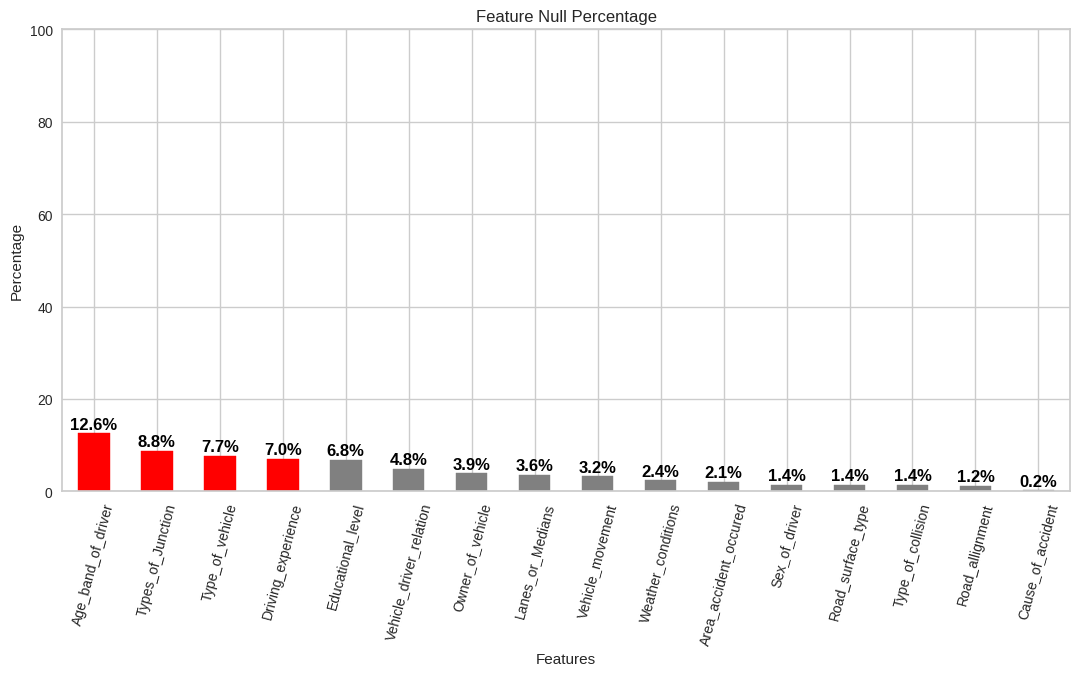

In [ ]:
fig, ax = plt.subplots(figsize=(13,6))
total = df.isnull().sum().sort_values(ascending=False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending=False)
missing = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing = missing.head(16)

missing = missing.drop(columns=['Total'])
# Plot the bar chart

missing.plot(kind='bar', rot=0, ax=ax)

# Set y-axis limits to 0-100
ax.set_ylim([0, 100])

# Rotate the x-axis labels
plt.xticks(rotation=75)


# Add axis labels and a title
plt.xlabel('Features')
plt.ylabel('Percentage')
plt.title('Feature Null Percentage')
ax.legend().remove()

for i, v in enumerate(missing['Percent']):
    ax.text(i, v + 1, f"{v:.1f}%", color='black', ha='center', fontweight='bold')

for i in range(4):
    ax.get_children()[i].set_color('red')
for i in range(4, len(missing)):
    ax.get_children()[i].set_color('grey')


plt.show()

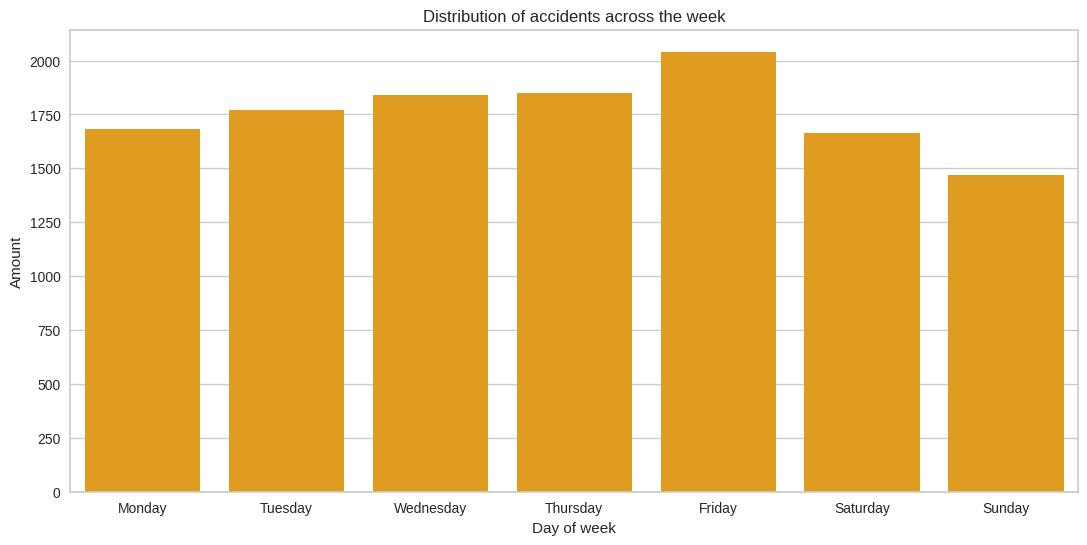

In [ ]:
week_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
fig, ax = plt.subplots(figsize=(13,6))

label_counts = df['Day_of_week'].value_counts()

# creating the bar plot
sns.barplot(x=label_counts.keys(),y=list(label_counts), data=df, order=week_order,color = 'orange')
plt.xlabel('Day of week')
plt.ylabel('Amount')
plt.title('Distribution of accidents across the week')

plt.show()

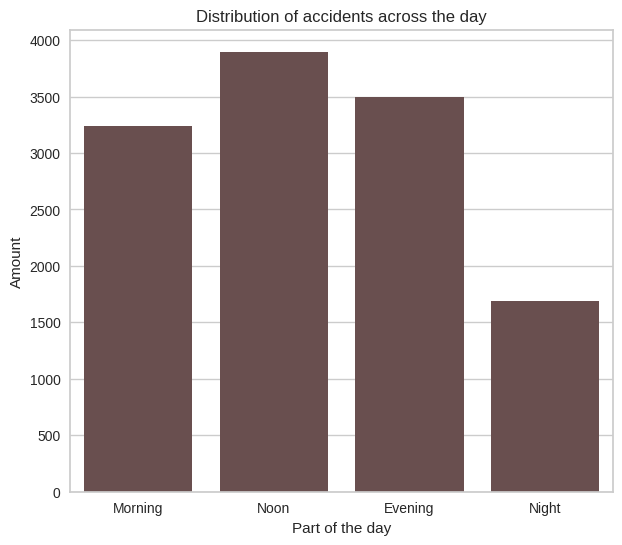

In [ ]:
bin_order = ['Morning', 'Noon', 'Evening','Night']
fig, ax = plt.subplots(figsize=(7,6))

label_counts = df['Time_bin'].value_counts()

# creating the bar plot
sns.barplot(x=label_counts.keys(),y=list(label_counts), data=df, order=bin_order,color = "#6d4b4b")
plt.xlabel('Part of the day')
plt.ylabel('Amount')
plt.title('Distribution of accidents across the day')

plt.show()

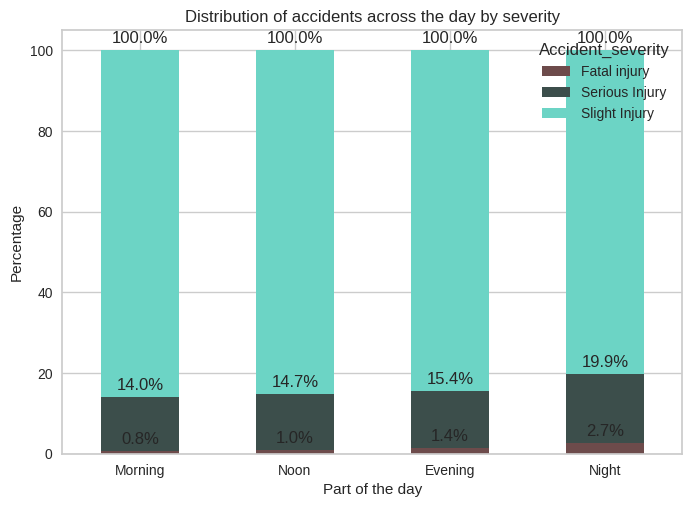

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
colors = ["#6d4b4b",  "#3c4e4b", "#6cd4c5"]

# Assuming you have imported the necessary libraries and have the required data

# Grouping the data by 'Light_conditions', 'Accident_severity', and calculating the count
grouped = df.groupby(['Time_bin', 'Accident_severity']).size().reset_index(name='Count')

# Pivot the data to make it suitable for a stacked bar plot
stacked_data = grouped.pivot(index='Time_bin', columns='Accident_severity', values='Count')

# Reorder the 'Light_conditions' categories based on the specified order
stacked_data = stacked_data.reindex(['Morning', 'Noon', 'Evening','Night'])

# Calculate the total count for each 'Light_conditions'
stacked_data['Total'] = stacked_data.sum(axis=1)

# Convert the count to percentages
stacked_data_percentage = stacked_data.div(stacked_data['Total'], axis=0) * 100

# Plotting the stacked bar plot
stacked_data_percentage.drop('Total', axis=1).plot(kind='bar', stacked=True, color=colors)

# Adding percentage labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, label_type='edge', fmt='%.1f%%', padding=3)

# Adding labels and title
plt.xlabel('Part of the day')
plt.ylabel('Percentage')
plt.title('Distribution of accidents across the day by severity')
plt.xticks(rotation=0)

# Display the plot
plt.show()

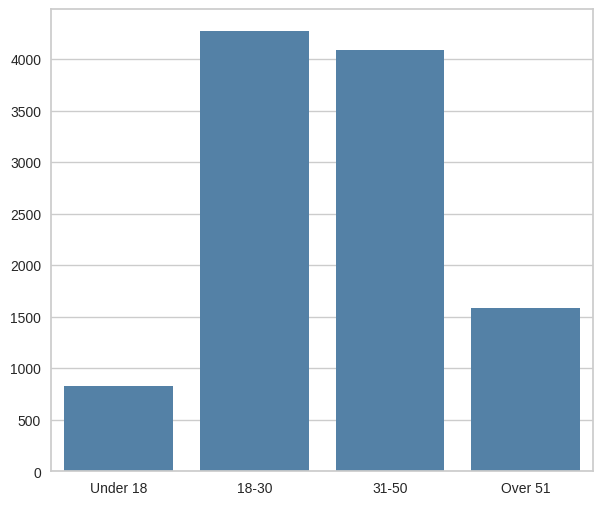

In [ ]:
bin_order = ['Under 18', '18-30', '31-50','Over 51']
fig, ax = plt.subplots(figsize=(7,6))

label_counts = df['Age_band_of_driver'].value_counts()

# creating the bar plot
sns.barplot(x=label_counts.keys(),y=list(label_counts), data=df, order=bin_order,color = 'steelblue')

plt.show()

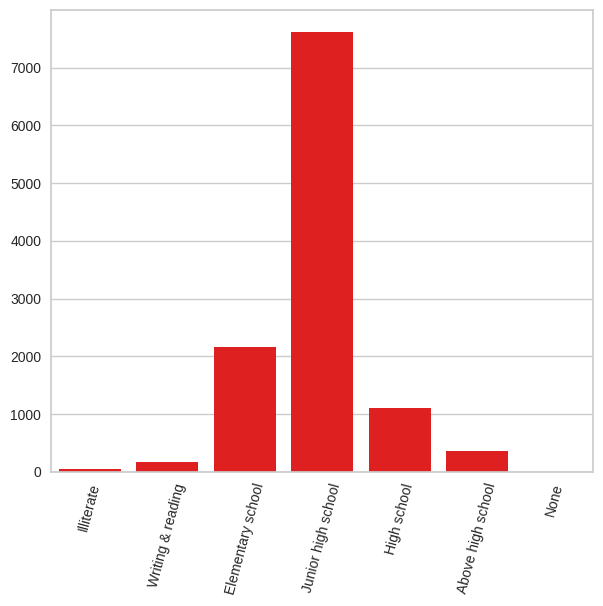

In [ ]:
Educational_level_bins = ['Illiterate','Writing & reading','Elementary school','Junior high school','High school','Above high school', 'None']
fig, ax = plt.subplots(figsize=(7,6))

label_counts = df['Educational_level'].value_counts()

# creating the bar plot
sns.barplot(x=label_counts.keys(),y=list(label_counts), data=df, order=Educational_level_bins,color = 'red')

plt.xticks(rotation=75)


plt.show()

Text(0.5, 1.0, 'Distribution of accidents across light conditions by severity')

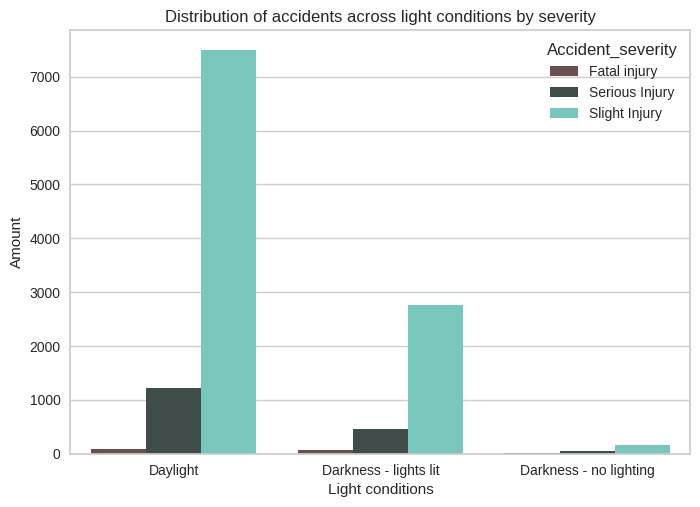

In [ ]:
bins = ['Daylight','Darkness - lights lit','Darkness - no lighting']
colors = ["#6d4b4b",  "#3c4e4b", "#6cd4c5"]
# Create the stacked bar plot
grouped = df.groupby(['Light_conditions', 'Accident_severity']).size().reset_index(name='Count')
sns.barplot(x='Light_conditions', y='Count', hue='Accident_severity', data=grouped, palette=colors,order=bins)

# Add labels and a title
# plt.xlabel('Light Conditions')
plt.xlabel('Light conditions')
plt.ylabel('Amount')
plt.title('Distribution of accidents across light conditions by severity')
# plt.title('Stacked Bar Plot: Light Conditions vs Accident Severity')

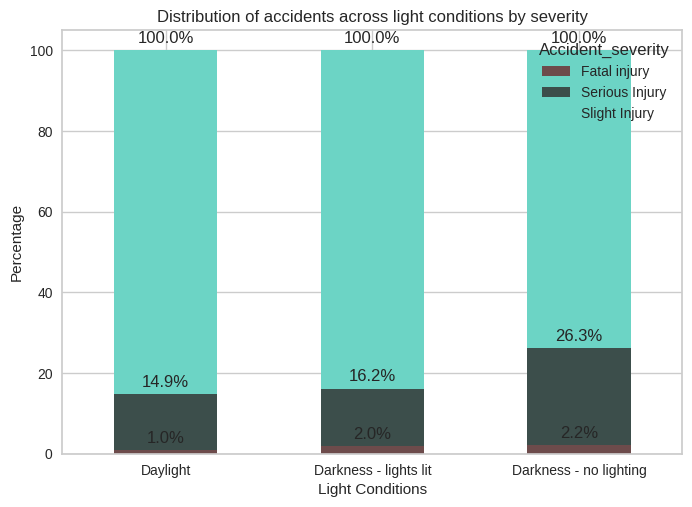

In [ ]:
colors = ["#6d4b4b",  "#3c4e4b", "#6cd4c5"]

# Assuming you have imported the necessary libraries and have the required data

# Grouping the data by 'Light_conditions', 'Accident_severity', and calculating the count
grouped = df.groupby(['Light_conditions', 'Accident_severity']).size().reset_index(name='Count')

# Pivot the data to make it suitable for a stacked bar plot
stacked_data = grouped.pivot(index='Light_conditions', columns='Accident_severity', values='Count')

# Reorder the 'Light_conditions' categories based on the specified order
stacked_data = stacked_data.reindex(['Daylight', 'Darkness - lights lit', 'Darkness - no lighting'])

# Calculate the total count for each 'Light_conditions'
stacked_data['Total'] = stacked_data.sum(axis=1)

# Convert the count to percentages
stacked_data_percentage = stacked_data.div(stacked_data['Total'], axis=0) * 100

# Plotting the stacked bar plot
stacked_data_percentage.drop('Total', axis=1).plot(kind='bar', stacked=True, color=colors)

# Adding percentage labels to the bars
for container in plt.gca().containers:
    plt.gca().bar_label(container, label_type='edge', fmt='%.1f%%', padding=3)

# Adding labels and title
plt.xlabel('Light Conditions')
plt.ylabel('Percentage')
plt.title('Distribution of accidents across light conditions by severity')
plt.xticks(rotation=0)

# Display the plot
plt.show()

Text(0.5, 1.0, 'Distribution of accidents across cause of accident by severity')

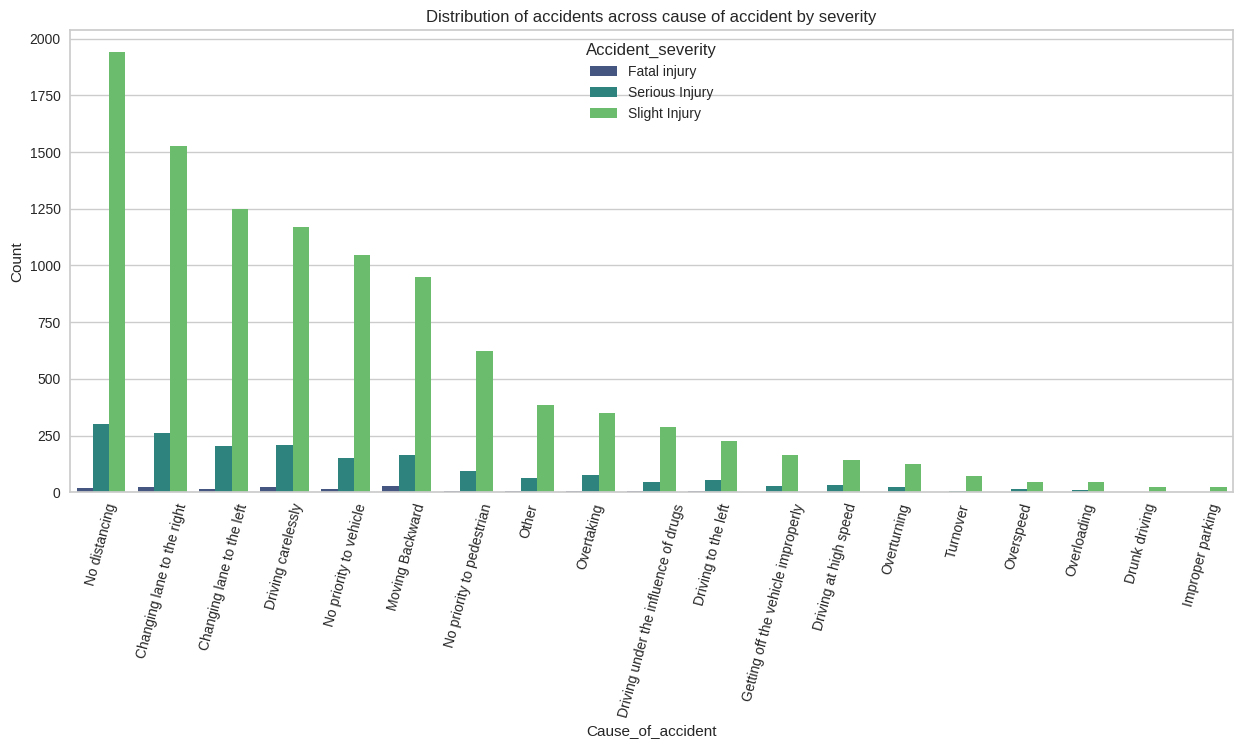

In [ ]:
grouped = df.groupby(['Cause_of_accident', 'Accident_severity']).size().reset_index(name='Count')
bins = sorted([(i,grouped[grouped['Cause_of_accident']==i]['Count'].sum()) for i in set(grouped['Cause_of_accident'])],key=lambda x:x[1],reverse = True)
bins = [i[0] for i in bins]

fig, ax = plt.subplots(figsize=(15,6))

# Create the stacked bar plot
grouped = df.groupby(['Cause_of_accident', 'Accident_severity']).size().reset_index(name='Count')
order = [(i for i in list(grouped['Cause_of_accident']))]
sns.barplot(x='Cause_of_accident', y='Count', hue='Accident_severity', data=grouped, palette='viridis',order = bins)
plt.xticks(rotation=75)

# Add labels and a title
# plt.xlabel('Light Conditions')
plt.ylabel('Count')
plt.title('Distribution of accidents across cause of accident by severity')
# plt.title('Stacked Bar Plot: Light Conditions vs Accident Severity')

In [ ]:
Cause_of_accident_encoding={'Moving Backward':'Low','Improper parking':'Low',None:None,'Changing lane to the left':'Medium','Changing lane to the right':'Medium',
                            'Overloading':'Medium','Other':'Other','No priority to vehicle':'High','No priority to pedestrian':'High','No distancing':'High',
                            'Getting off the vehicle improperly':'Low','Overspeed':'Severe','Driving carelessly':'High','Driving at high speed':'High',
                            'Driving to the left':'Medium','Overturning':'Medium','Turnover':'High','Driving under the influence of drugs':'Severe','Drunk driving':'Severe',
                            'Overtaking':'Medium'}
df['Cause_of_accident'] = df['Cause_of_accident'].apply(lambda x: Cause_of_accident_encoding[x])

In [ ]:
numeric_columns_dict = {'Feature Name': [],'Accident_severity':[], 'Average': [], 'Standard Deviation': []}
numeric_columns = ['Number_of_vehicles_involved']
for column in numeric_columns:
  for sever_lvl in set(df['Accident_severity']):
    numeric_columns_dict['Accident_severity'].append(sever_lvl)
    numeric_columns_dict['Feature Name'].append(column)
    numeric_columns_dict['Average'].append(df[df['Accident_severity']==sever_lvl][column].mean())
    numeric_columns_dict['Standard Deviation'].append(df[df['Accident_severity']==sever_lvl][column].std())
numeric_columns_df = pd.DataFrame(numeric_columns_dict)
# numeric_columns_df.to_csv('numeric_columns.csv')
print(numeric_columns_df)

                  Feature Name Accident_severity  Average  Standard Deviation
0  Number_of_vehicles_involved     Slight Injury     2.07                0.67
1  Number_of_vehicles_involved      Fatal injury     1.80                0.55
2  Number_of_vehicles_involved    Serious Injury     1.90                0.78


# Impute missing values

In [ ]:
def impute_missing_values(column):
      most_common_value = df[column].mode()[0]
      df[column].fillna(most_common_value,inplace = True)

In [ ]:
if Set_IMV:
  columns_with_null = df.columns[df.isnull().any()].tolist()
  print(columns_with_null)

['Age_band_of_driver', 'Sex_of_driver', 'Educational_level', 'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle', 'Owner_of_vehicle', 'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment', 'Types_of_Junction', 'Road_surface_type', 'Weather_conditions', 'Type_of_collision', 'Vehicle_movement', 'Cause_of_accident']


In [ ]:
if Set_IMV:
  # 'Age_band_of_driver' - most_frquent_value
  impute_missing_values('Age_band_of_driver')
  # 'Sex_of_driver' - most_frquent_value
  impute_missing_values('Sex_of_driver')
  # 'Educational_level' - most_frquent_value
  impute_missing_values('Educational_level')
  # 'Vehicle_driver_relation' - most_frquent_value
  impute_missing_values('Vehicle_driver_relation')
  # 'Driving_experience' - fiiled with most frquent_value out of Age_band
  ages = ['Under 18', '18-30', '31-50','Over 51']
  for age_band in ages:
    most_frequent_value = df.loc[df['Age_band_of_driver'] == age_band, 'Driving_experience'].mode()[0]
    df.loc[(df['Age_band_of_driver'] == age_band) & (df['Driving_experience'].isna()), 'Driving_experience'] = most_frequent_value
  # 'Type_of_vehicle' - most_frquent_value
  impute_missing_values('Type_of_vehicle')
  # 'Owner_of_vehicle' - most_frquent_value
  impute_missing_values('Owner_of_vehicle')
  # 'Area_accident_occured' - most_frquent_value
  impute_missing_values('Area_accident_occured')
  # 'Lanes_or_Medians' - most_frquent_value
  impute_missing_values('Lanes_or_Medians')
  # 'Road_allignment' - most_frquent_value
  impute_missing_values('Road_allignment')
  # 'Types_of_Junction' - fiiled with No Junction
  df['Types_of_Junction'].fillna("No junction",inplace = True)
  # 'Road_surface_type' - most_frquent_value
  impute_missing_values('Road_surface_type')
  # 'Weather_conditions' - most_frquent_value
  impute_missing_values('Weather_conditions')
  # 'Type_of_collision' - most_frquent_value
  impute_missing_values('Type_of_collision')
  # 'Vehicle_movement' - most_frquent_value
  impute_missing_values('Vehicle_movement')
  # 'Cause_of_accident' - filled with "Unkown"
  df['Cause_of_accident'].fillna("Unkown",inplace = True)

#Encoding

In [ ]:
Age_band_of_driver_encoding = {'Under 18':0,'18-30':0.333333,'31-50':0.6666667,'Over 51':1,None:None }
df['Age_band_of_driver'] = df['Age_band_of_driver'].apply(lambda x: Age_band_of_driver_encoding[x])
Educational_level_encoding = {'Illiterate':0,'Writing & reading':0.2,'Elementary school':0.4,'Junior high school':0.6,'High school':0.8,'Above high school':1, None:None }
df['Educational_level'] = df['Educational_level'].apply(lambda x: Educational_level_encoding[x])
Driving_experience_encoding = {'No Licence':0,'Below 1yr':0.2,'1-2yr':0.4,'2-5yr':0.6,'5-10yr':0.8,'Above 10yr':1, None:None }
df['Driving_experience'] = df['Driving_experience'].apply(lambda x: Driving_experience_encoding[x])
Light_conditions_encoding = {'Darkness - no lighting':0,'Darkness - lights lit':0.5,'Daylight':1, None:None }
df['Light_conditions'] = df['Light_conditions'].apply(lambda x: Light_conditions_encoding[x])
# Cause_of_accident_encoding={'Moving Backward':0,'Improper parking':0,None:None,'Changing lane to the left':0.3333333,'Changing lane to the right':0.3333333,
#                             'Overloading':0.3333333,'Other':0.5,'No priority to vehicle':0.6666666,'No priority to pedestrian':0.6666666,'No distancing':0.6666666,
#                             'Getting off the vehicle improperly':0,'Overspeed':1,'Driving carelessly':0.6666666,'Driving at high speed':0.6666666,
#                             'Driving to the left':0.3333333,'Overturning':0.3333333,'Turnover':0.6666666,'Driving under the influence of drugs':1,'Drunk driving':1,
#                             'Overtaking':0.3333333}
Cause_of_accident_encoding={'Low':0,'Medium':0.3333333,'Other':0.5,'Unkown':0.5,None:None,'High':0.6666666,'Severe':1}
df['Cause_of_accident'] = df['Cause_of_accident'].apply(lambda x: Cause_of_accident_encoding[x])
Accident_severity_encoding = {'Slight Injury':0,'Serious Injury':1,'Fatal injury':2}
df['Accident_severity'] = df['Accident_severity'].apply(lambda x: Accident_severity_encoding[x])
Type_of_vehicle_encoding = {'Tiny':0,'Small':0.3333333,'Medium': 0.6666666,'Big':1, None:None}
df['Type_of_vehicle'] = df['Type_of_vehicle'].apply(lambda x: Type_of_vehicle_encoding[x])
Time_bin_encoding = {'Night':1, 'Morning':0, 'Noon':0.3333333, 'Evening':0.6666666}
df['Time_bin'] = df['Time_bin'].apply(lambda x: Time_bin_encoding[x])
df['Time_bin'] = df['Time_bin'].astype(float)

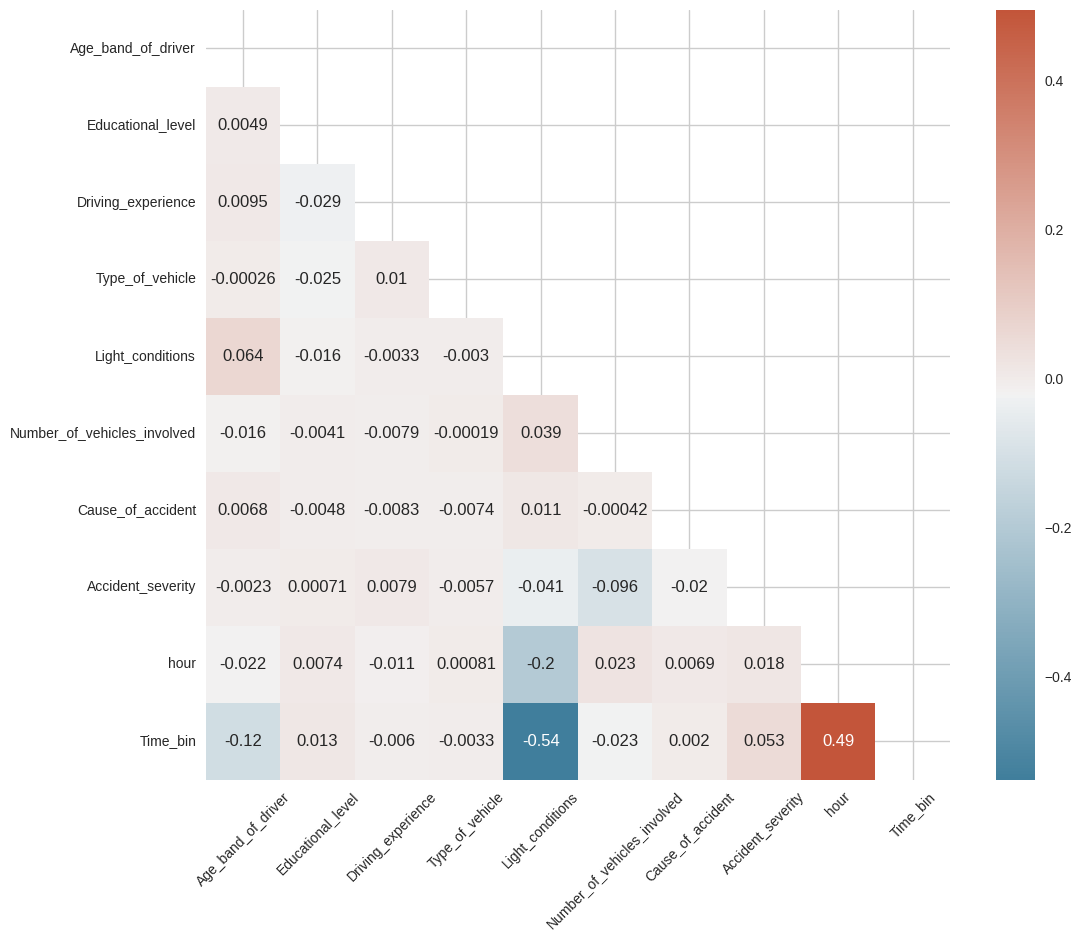

In [ ]:
# Crate correlation heat map
corr_mat = df.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr_mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr_mat, annot=True, mask=mask, cmap=cmap)
plt.xticks(rotation=45)
f.show()

In [ ]:
cat_to_encode=['Sex_of_driver','Day_of_week','Vehicle_driver_relation','Type_of_vehicle','Owner_of_vehicle','Area_accident_occured','Lanes_or_Medians','Road_allignment','Types_of_Junction',
              'Road_surface_type','Road_surface_conditions','Weather_conditions','Type_of_collision','Vehicle_movement']
enc = OneHotEncoder()

encoded_data = enc.fit_transform(df[cat_to_encode]).todense()
encoded_data_df = pd.DataFrame(encoded_data,columns=enc.get_feature_names_out())

df.drop(cat_to_encode,axis=1,inplace=True)
encoded_df = pd.concat([df,encoded_data_df],axis=1)

In [ ]:
X = encoded_df.copy()
X.drop(['Accident_severity'],axis=1,inplace=True)
Y = encoded_df['Accident_severity']

#Feature Selection

In [ ]:
if Set_FS == 1:
  r_scaler = preprocessing.MinMaxScaler()
  r_scaler.fit(X)
  modified_data = pd.DataFrame(r_scaler.transform(X), columns=X.columns)
  X = modified_data.loc[:,modified_data.columns!='satisfaction']
  selector = SelectKBest(chi2, k=45)
  selector.fit(X, Y)
  X_new = selector.transform(X)
  chi_importance = X.columns[selector.get_support(indices=True)]
  X = X[chi_importance]

#Modeling

In [ ]:
exp = ClassificationExperiment()
exp = setup(data=X_train, target=y_train,fold=3)
exp.add_metric('Balanced Accuracy','Balanced Accuracy',balanced_accuracy_score,greater_is_better = True)
best = exp.compare_models(sort='Balanced Accuracy')

,Description,Value
0,Session id,8302
1,Target,Accident_severity
2,Target type,Multiclass
3,Original data shape,"(9852, 46)"
4,Transformed data shape,"(9852, 46)"
5,Transformed train set shape,"(6896, 46)"
6,Transformed test set shape,"(2956, 46)"
7,Numeric features,45
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,Balanced Accuracy,TT (Sec)
dt,Decision Tree Classifier,0.7564,0.5522,0.7564,0.7623,0.7593,0.1023,0.1024,0.3965,0.3633
nb,Naive Bayes,0.0595,0.5273,0.0595,0.7633,0.0813,0.0034,0.0133,0.3652,0.1933
xgboost,Extreme Gradient Boosting,0.8351,0.6219,0.8351,0.7770,0.7884,0.0826,0.1107,0.3598,5.2200
qda,Quadratic Discriminant Analysis,0.1597,0.5150,0.1597,0.7520,0.2042,0.0039,0.0151,0.3588,0.1267
et,Extra Trees Classifier,0.8261,0.6009,0.8261,0.7607,0.7827,0.0643,0.0801,0.3521,1.3300
rf,Random Forest Classifier,0.8314,0.6200,0.8314,0.7625,0.7839,0.0632,0.0832,0.3513,2.2067
lightgbm,Light Gradient Boosting Machine,0.8376,0.6208,0.8376,0.7648,0.7825,0.0483,0.0761,0.3469,1.9867
gbc,Gradient Boosting Classifier,0.8430,0.6251,0.8430,0.7679,0.7789,0.0224,0.0537,0.3380,5.3333
ada,Ada Boost Classifier,0.8451,0.5634,0.8451,0.8058,0.7776,0.0136,0.0539,0.3363,0.5567
knn,K Neighbors Classifier,0.8283,0.5250,0.8283,0.7401,0.7737,0.0100,0.0147,0.3356,0.6233


Processing:   0%|          | 0/65 [00:00<?, ?it/s]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y ,random_state=42)
sample_weights = compute_sample_weight(class_weight='balanced',y=y_train)

In [ ]:
if Set_model == 0:
    classifier = XGBClassifier()
if Set_model == 1:
    classifier = DecisionTreeClassifier()
if Set_model == 2:
    classifier = LGBMClassifier()
if Set_model == 3:
    classifier = GradientBoostingClassifier()
if Set_model == 4:
   classifier = RandomForestClassifier()

if Set_IM == 0:
  classifier = classifier.fit(X_train,y_train)
  y_pred = classifier.predict(X_test)
if Set_IM == 1:
  classifier = classifier.fit(X_train,y_train,sample_weights)
  y_pred = classifier.predict(X_test)
if Set_IM == 2:
  classifiers = []
  for label in range(2,0,-1):
    temp_X_train = X_train.copy()
    temp_y_train = y_train.copy()
    temp_y_train = pd.DataFrame(temp_y_train,columns=['Accident_severity'])
    temp_y_train['Accident_severity'] = temp_y_train['Accident_severity'].apply(lambda x: 0 if x != label else 1)
    counter = Counter(temp_y_train['Accident_severity'])
    estimate = counter[0] / counter[1]
    classifier = classifier.fit(temp_X_train,temp_y_train)
    classifiers.append(classifier)
  y_pred_2 = classifiers[0].predict(X_test)
  y_pred_1 = classifiers[1].predict(X_test)
  for i, val in enumerate(y_pred_2):
    if val == 1:
      y_pred_2[i] = 2
    if val == 0:
      y_pred_2[i] = y_pred_1[i]
  y_pred = y_pred_2
if Set_IM == 3:
  oversampler = RandomOverSampler(sampling_strategy="minority", random_state=42)
  X_train, y_train = oversampler.fit_resample(X_train, y_train)
  classifier = classifier.fit(X_train,y_train)
  y_pred = classifier.predict(X_test)

# Inital Evaluation

In [ ]:
import numpy as np

def compute_recall_precision(predictions, references, num_classes):
    recalls = np.zeros(num_classes)
    precisions = np.zeros(num_classes)

    for i in range(num_classes):
        true_positives = np.sum((predictions == i) & (references == i))
        false_positives = np.sum((predictions == i) & (references != i))
        false_negatives = np.sum((predictions != i) & (references == i))

        recalls[i] = true_positives / (true_positives + false_negatives)
        precisions[i] = true_positives / (true_positives + false_positives)

    return recalls, precisions

In [ ]:
recalls, precisions = compute_recall_precision(y_pred, y_test, 3)

for i in range(3):
    print(f"Class {i}: Recall = {recalls[i]}, Precision = {precisions[i]}")

Class 0: Recall = nan, Precision = 0.0
Class 1: Recall = nan, Precision = 0.0


In [ ]:
print(f"Accuracy: {accuracy_score(y_test,y_pred)}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test,y_pred)}")
print(f"Micro Precision: {precision_score(y_test,y_pred,average='micro')}")
print(f"Micro Recall: {recall_score(y_test,y_pred,average='micro')}")
print(f"Micro F1-score: {f1_score(y_test,y_pred,average='micro')}")
print(f"Macro Precision: {precision_score(y_test,y_pred,average='macro')}")
print(f"Macro Recall: {recall_score(y_test,y_pred,average='macro')}")
print(f"Macro F1-score: {f1_score(y_test,y_pred,average='macro')}")

Accuracy: 0.7106331168831169
Balanced Accuracy: 0.5965476310738458
Micro Precision: 0.7106331168831169
Micro Recall: 0.7106331168831169
Micro F1-score: 0.7106331168831169
Macro Precision: 0.564154296545596
Macro Recall: 0.5965476310738458
Macro F1-score: 0.5658248497973615


#Find The Best Hyperparameters

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer


dt_model = DecisionTreeClassifier(random_state=42)

balanced_scorer = make_scorer(balanced_accuracy_score,greater_is_better=True)

parameters = {'max_depth': np.arange(3, 11, 1),
              'min_samples_split': [2, 5, 10]}

random_search = RandomizedSearchCV(estimator=dt_model, param_distributions=parameters,
                                 scoring= balanced_scorer, cv=5, n_jobs=-1)

random_search.fit(X_train, y_train,sample_weight=sample_weights)
print(random_search.best_params_)

{'min_samples_split': 5, 'max_depth': 9}


In [ ]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

xgb_model = xgb.XGBClassifier(objective="multi:softprob", random_state=42)

parameters = {'n_estimators': np.arange(10, 50, 200),
              'learning_rate': np.linspace(0.01, 0.1,10),
              'max_depth': np.arange(3, 10,1)}

random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=parameters,
                                   scoring=balanced_scorer, cv=5, n_jobs=-1)

random_search.fit(X_train, y_train,sample_weight=sample_weights)
print(random_search.best_params_)

{'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.05000000000000001}


In [ ]:
import lightgbm as lgb

lgbm_model = lgb.LGBMClassifier(objective='multiclass', random_state=42)

parameters = {'n_estimators': np.arange(50, 200,10),
              'learning_rate': np.linspace(0.01, 0.1,10),
              'max_depth': np.arange(3, 10,1)}

random_search = RandomizedSearchCV(estimator=lgbm_model, param_distributions=parameters,
                                   scoring= balanced_scorer, cv=5, n_jobs=-1)

random_search.fit(X_train, y_train,sample_weight=sample_weights)
print(random_search.best_params_)

{'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.06000000000000001}


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV

gb_model = GradientBoostingClassifier(random_state=42)

parameters = {'n_estimators': np.arange(50,200,10),
              'learning_rate': np.linspace(0.01, 0.1, 10),
              'max_depth': np.arange(3, 11, 1)}

random_search = RandomizedSearchCV(estimator=gb_model, param_distributions=parameters,
                                 scoring= balanced_scorer, cv=5, n_jobs=-1)

random_search.fit(X_train, y_train,sample_weight=sample_weights)
print(random_search.best_params_)

{'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.09000000000000001}


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

rf_model = RandomForestClassifier(random_state=42)

parameters = {'n_estimators': np.arange(50,200,10),
              'max_depth': np.arange(3, 11, 1),
              'min_samples_split': [2, 5, 10]}

random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=parameters,
                                 scoring= balanced_scorer, cv=5, n_jobs=-1)

random_search.fit(X_train, y_train,sample_weight=sample_weights)
print(random_search.best_params_)

{'n_estimators': 190, 'min_samples_split': 2, 'max_depth': 6}


#Evaluation

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score, classification_report

sample_weights = compute_sample_weight(
      class_weight='balanced',
      y=y_train)


def evaluate_model(model, X_train, y_train, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print("Accuracy: {:.4f}".format(accuracy))
    print("Balanced Accuracy: {:.4f}".format(balanced_accuracy))
    print("Classification Report:\n", report)

# Define the hyperparameters for each model
model1_params = {'min_samples_split': 5, 'max_depth': 9}
model2_params = {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.05}
model3_params = {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.06}
model4_params = {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.09}
model5_params = {'n_estimators': 190, 'min_samples_split': 2, 'max_depth': 6}

# Initialize the models
model1 = DecisionTreeClassifier(**model1_params).fit(X_train, y_train,sample_weights)
model2 = XGBClassifier(**model2_params).fit(X_train, y_train,sample_weights)
model3 = LGBMClassifier(**model3_params).fit(X_train, y_train,sample_weights)
model4 = GradientBoostingClassifier(**model4_params).fit(X_train, y_train,sample_weights)
model5 = RandomForestClassifier(**model5_params).fit(X_train, y_train,sample_weights)

In [ ]:
# Evaluate each model
print("Model 1 - DecisionTreeClassifier")
evaluate_model(model1, X_train, y_train, X_test, y_test)

print("\nModel 2 - XGBClassifier")
evaluate_model(model2, X_train, y_train, X_test, y_test)

print("\nModel 3 - LGBMClassifier")
evaluate_model(model3, X_train, y_train, X_test, y_test)

print("\nModel 4 - GradientBoostingClassifier")
evaluate_model(model4, X_train, y_train, X_test, y_test)

print("\nModel 5 - RandomForestClassifier")
evaluate_model(model5, X_train, y_train, X_test, y_test)


Model 1 - DecisionTreeClassifier
Accuracy: 0.5175
Balanced Accuracy: 0.4996
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.54      0.67      2084
           1       0.20      0.38      0.26       349
           2       0.03      0.58      0.06        31

    accuracy                           0.52      2464
   macro avg       0.37      0.50      0.33      2464
weighted avg       0.78      0.52      0.61      2464


Model 2 - XGBClassifier
Accuracy: 0.6027
Balanced Accuracy: 0.5459
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.63      0.74      2084
           1       0.23      0.42      0.30       349
           2       0.06      0.58      0.10        31

    accuracy                           0.60      2464
   macro avg       0.39      0.55      0.38      2464
weighted avg       0.78      0.60      0.67      2464


Model 3 - LGBMClassifier
Accuracy: 0.5958
Bal

#Evaluate the choise of hypeparameters on the test set

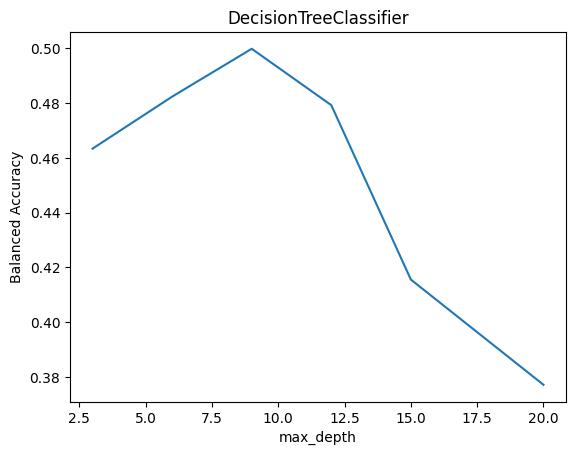

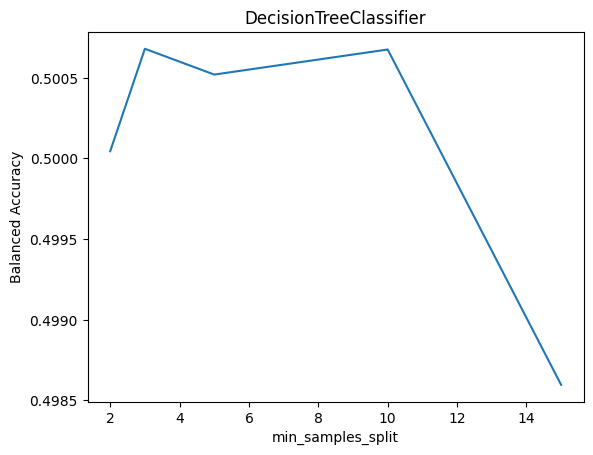

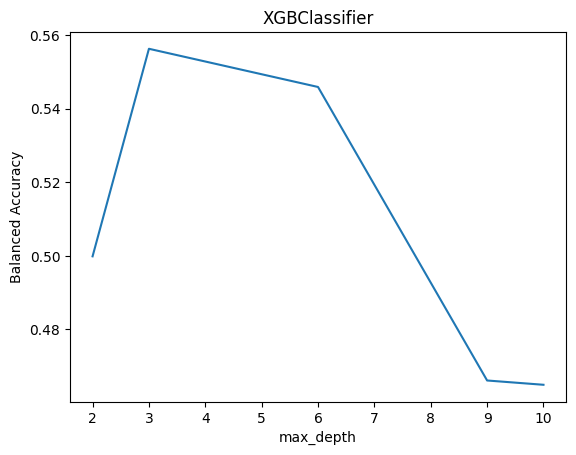

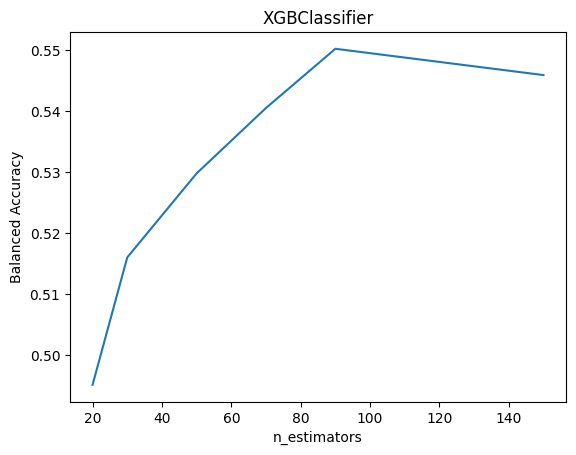

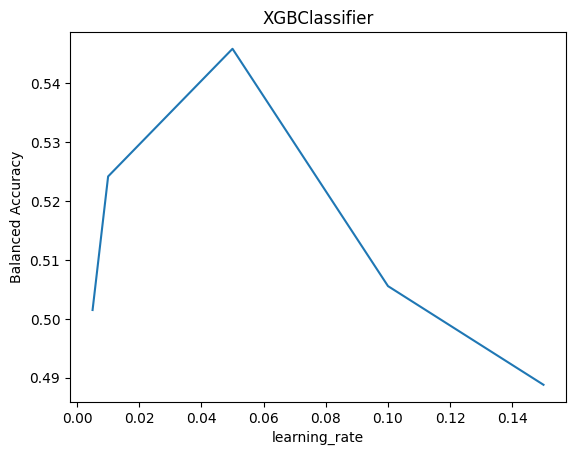

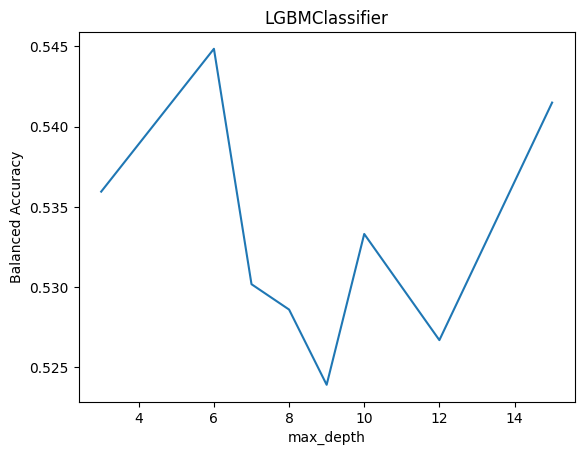

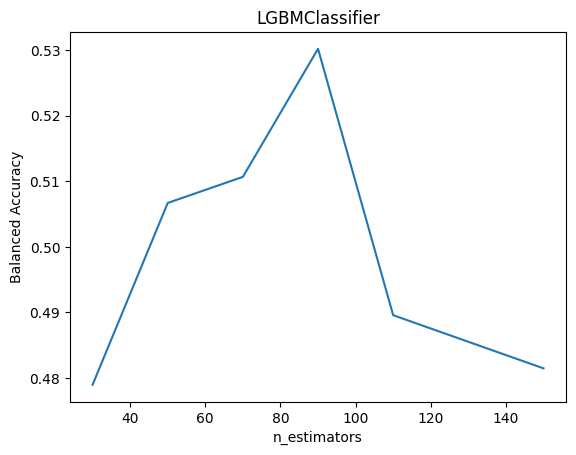

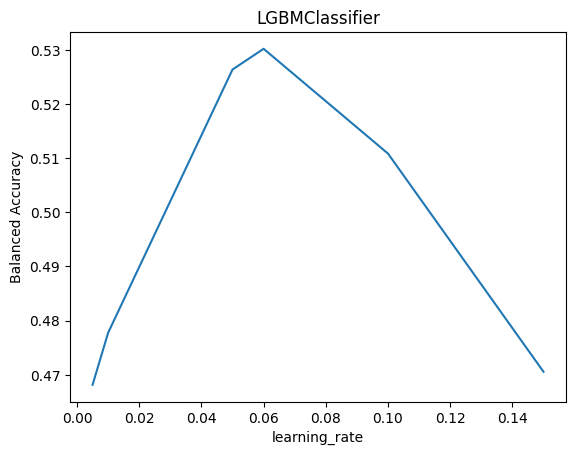

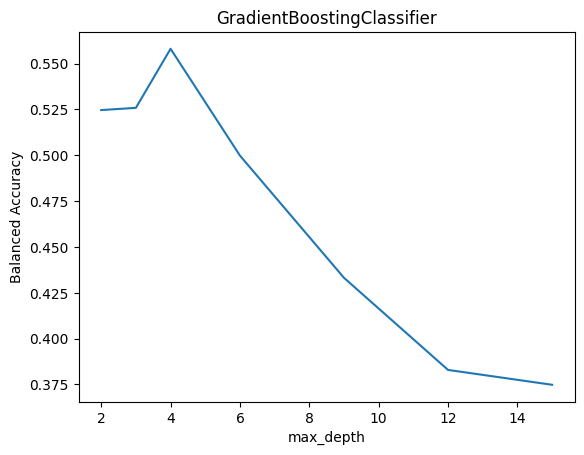

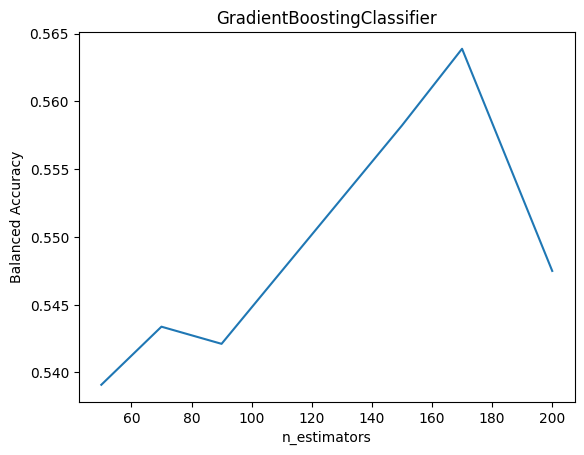

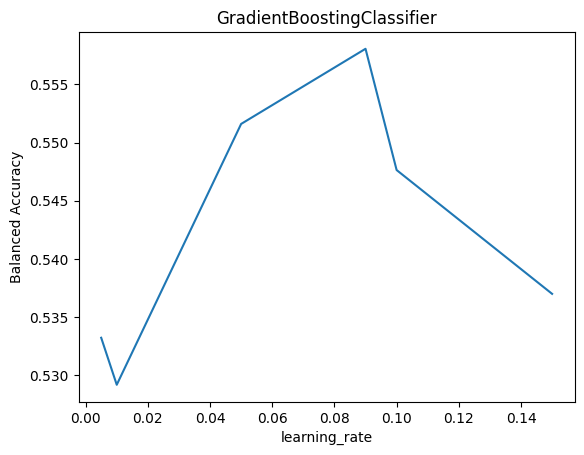

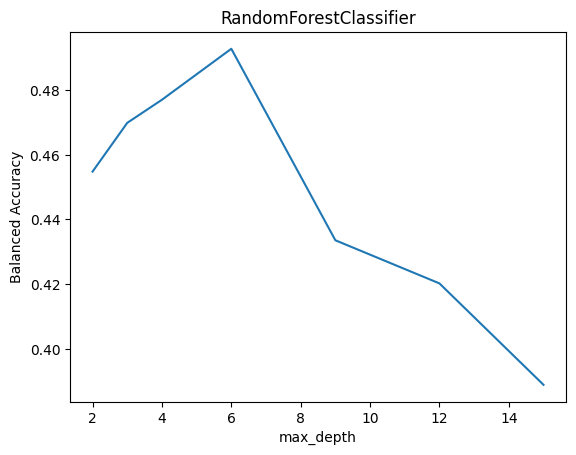

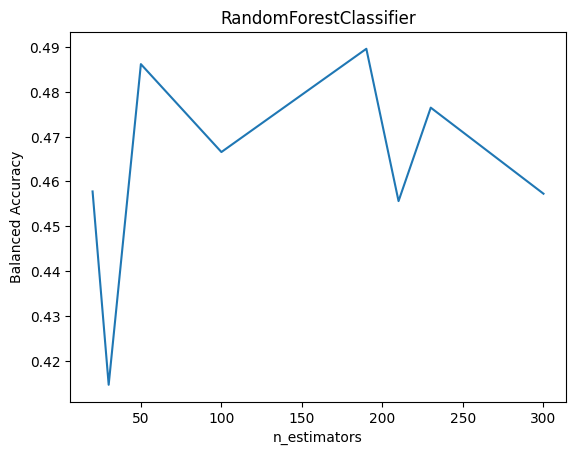

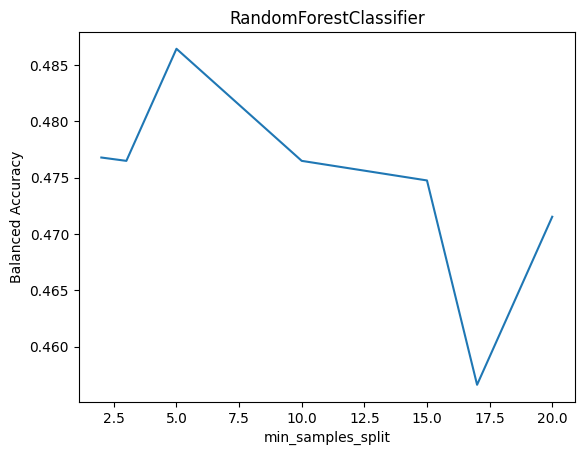

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import balanced_accuracy_score, accuracy_score

def plot_balanced_accuracy(model, X_train, y_train, X_test, y_test, param_name, param_values):
    accuracy_values = []

    for param_value in param_values:
        if param_name in model.get_params():
            model.set_params(**{param_name: param_value})
        else:
            setattr(model, param_name, param_value)

        model.fit(X_train, y_train,sample_weights)
        y_pred = model.predict(X_test)
        accuracy = balanced_accuracy_score(y_test, y_pred)
        accuracy_values.append(accuracy)

    plt.plot(param_values, accuracy_values)
    plt.xlabel(param_name)
    plt.ylabel('Balanced Accuracy')
    plt.title(f'{model.__class__.__name__}')
    plt.show()

# Define the hyperparameters and their ranges for each model
model11_params = {'max_depth': [3, 6, 9, 12, 15, 20]}
model12_params = {'min_samples_split': [2,3,5,10,15]}

model21_params = {'max_depth': [2, 3, 6, 9, 10]}
model22_params = {'n_estimators': [20,30,50, 70, 90,150]}
model23_params = {'learning_rate': [0.005,0.01, 0.05, 0.1, 0.15]}

model31_params = {'max_depth': [3, 6,7,8, 9,10, 12, 15]}
model32_params = {'n_estimators': [30,50, 70,90,110,150]}
model33_params = {'learning_rate': [0.005,0.01, 0.05,0.06, 0.1, 0.15]}

model41_params = {'max_depth': [2, 3,4, 6, 9, 12, 15]}
model42_params = {'n_estimators': [50, 70, 90,150,170,200]}
model43_params = {'learning_rate': [0.005,0.01, 0.05, 0.09 ,0.1, 0.15]}

model51_params = {'max_depth': [2, 3,4, 6, 9, 12, 15]}
model52_params = {'n_estimators': [20,30,50,100,190, 210, 230,300]}
model53_params = {'min_samples_split': [2,3,5,10,15,17,20]}



# Initialize the models
# {'min_samples_split': 5, 'max_depth': 9}
model11 = DecisionTreeClassifier(min_samples_split=5)
model12 = DecisionTreeClassifier(max_depth=9)
# {'n_estimators': 150, 'max_depth': 6, 'learning_rate': 0.05}
model21 = XGBClassifier(n_estimators=150, learning_rate=0.05)
model22 = XGBClassifier(max_depth=6, learning_rate=0.05)
model23 = XGBClassifier(n_estimators=150, learning_rate=0.05)

# {'n_estimators': 90, 'max_depth': 7, 'learning_rate': 0.06}
model31 = LGBMClassifier(n_estimators=90, learning_rate=0.06)
model32 = LGBMClassifier(max_depth=7, learning_rate=0.06)
model33 = LGBMClassifier(max_depth=7, n_estimators=90)

# {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.09}
model41 = GradientBoostingClassifier(n_estimators=150, learning_rate=0.09)
model42 = GradientBoostingClassifier(max_depth=4, learning_rate=0.09)
model43 = GradientBoostingClassifier(max_depth=4, n_estimators=150)

# {'n_estimators': 190, 'min_samples_split': 2, 'max_depth': 6}
model51 = RandomForestClassifier(n_estimators=190, min_samples_split=2)
model52 = RandomForestClassifier(max_depth=4, min_samples_split=2)
model53 = RandomForestClassifier(max_depth=4, n_estimators=190)


# Plot balanced accuracy for each model
plot_balanced_accuracy(model11, X_train, y_train, X_test, y_test, 'max_depth', model11_params['max_depth'])
plot_balanced_accuracy(model12, X_train, y_train, X_test, y_test, 'min_samples_split', model12_params['min_samples_split'])


plot_balanced_accuracy(model21, X_train, y_train, X_test, y_test, 'max_depth', model21_params['max_depth'])
plot_balanced_accuracy(model22, X_train, y_train, X_test, y_test, 'n_estimators', model22_params['n_estimators'])
plot_balanced_accuracy(model23, X_train, y_train, X_test, y_test, 'learning_rate', model23_params['learning_rate'])


plot_balanced_accuracy(model31, X_train, y_train, X_test, y_test, 'max_depth', model31_params['max_depth'])
plot_balanced_accuracy(model32, X_train, y_train, X_test, y_test, 'n_estimators', model32_params['n_estimators'])
plot_balanced_accuracy(model33, X_train, y_train, X_test, y_test, 'learning_rate', model33_params['learning_rate'])

plot_balanced_accuracy(model41, X_train, y_train, X_test, y_test, 'max_depth', model41_params['max_depth'])
plot_balanced_accuracy(model42, X_train, y_train, X_test, y_test, 'n_estimators', model42_params['n_estimators'])
plot_balanced_accuracy(model43, X_train, y_train, X_test, y_test, 'learning_rate', model43_params['learning_rate'])

plot_balanced_accuracy(model51, X_train, y_train, X_test, y_test, 'max_depth', model51_params['max_depth'])
plot_balanced_accuracy(model52, X_train, y_train, X_test, y_test, 'n_estimators', model52_params['n_estimators'])
plot_balanced_accuracy(model53, X_train, y_train, X_test, y_test, 'min_samples_split', model53_params['min_samples_split'])


#Advance Models Analysis

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score,precision_recall_curve,average_precision_score

def advance_analysis(model, X_test, y_test):
    # Generate predictions
    y_pred = model.predict(X_test)

    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Generate predictions
    y_probs = model.predict_proba(X_test)

    # Compute ROC curve and AUC for each class
    fpr = dict()
    tpr = dict()
    auc = dict()
    y_test_encoded = pd.get_dummies(y_test)
    for i in range(len(model.classes_)):
        fpr[i], tpr[i], _ = roc_curve(y_test_encoded[i], y_probs[:, i])
        auc[i] = roc_auc_score(y_test_encoded[i], y_probs[:, i])

    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    label = {0:'Slight injury', 1:'Serious injury',2:'Fatal injury'}
    for i in range(len(model.classes_)):
        plt.plot(fpr[i], tpr[i], label=f"{label[i]} (AUC = {auc[i]:.2f})")
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC) Curve")
    plt.legend()
    plt.show()

    y_probs = model.predict_proba(X_test)

    # Compute Precision-Recall curve and average precision for each class
    precision = dict()
    recall = dict()
    average_precision = dict()

    for i in range(len(model.classes_)):
        precision[i], recall[i], _ = precision_recall_curve(y_test_encoded[i], y_probs[:, i])
        average_precision[i] = average_precision_score(y_test_encoded[i], y_probs[:, i])

    # Plot Precision-Recall curves for each class
    label = {0:'Slight injury', 1:'Serious injury',2:'Fatal injury'}
    plt.figure(figsize=(8, 6))
    for i in range(len(model.classes_)):
        plt.plot(recall[i], precision[i], label=f"{label[i]} (Avg Precision = {average_precision[i]:.2f})")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()

    # Explain model's decision using SHAP values
    explainer = shap.Explainer(model)
    shap_values = explainer.shap_values(X_test)

    # Summarize feature importance using SHAP values
    shap.summary_plot(shap_values, X_test, feature_names=X_test.columns, plot_type='bar',class_names=list(label.values()))

Confusion Matrix:
[[1319  499  266]
 [ 159  148   42]
 [   9    4   18]]


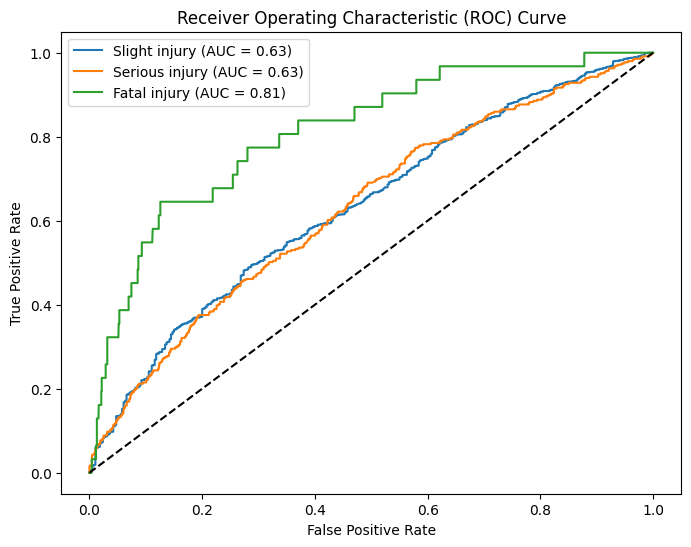

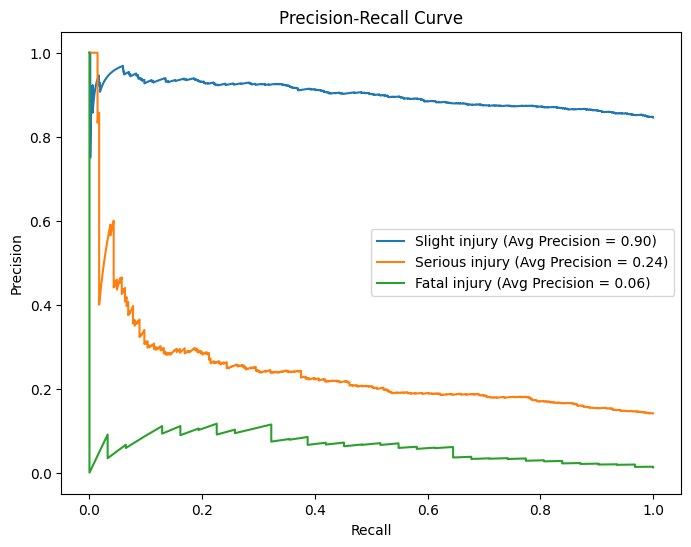

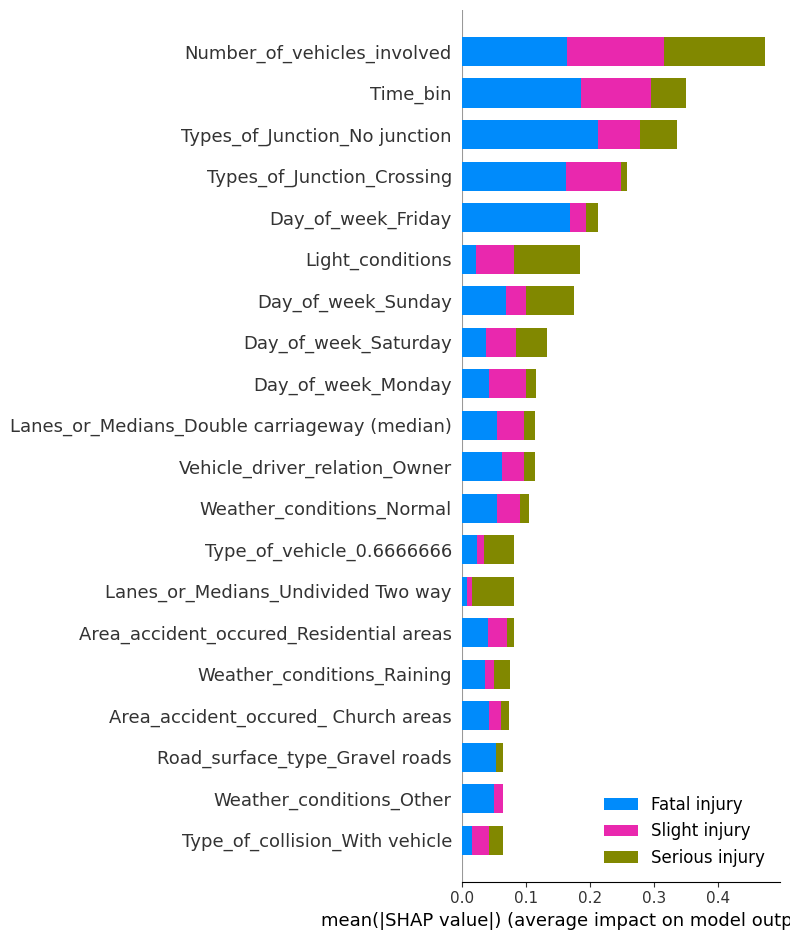

In [ ]:
# model2 = XGBClassifier
advance_analysis(model2, X_test, y_test)

Confusion Matrix:
[[1306  511  267]
 [ 161  145   43]
 [  10    4   17]]


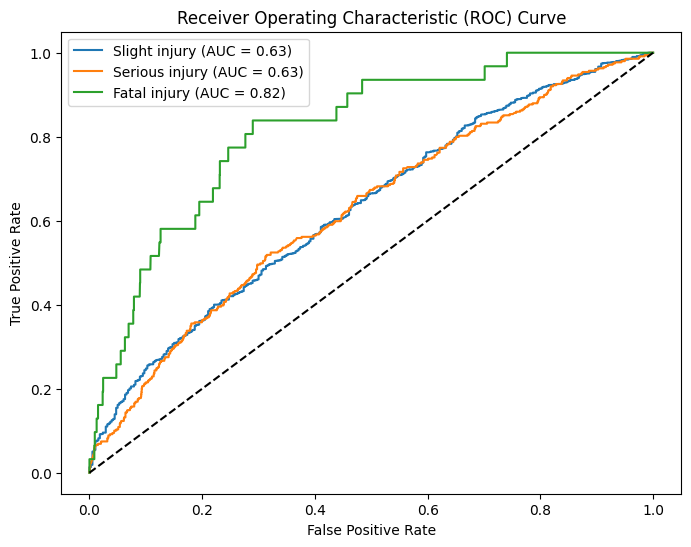

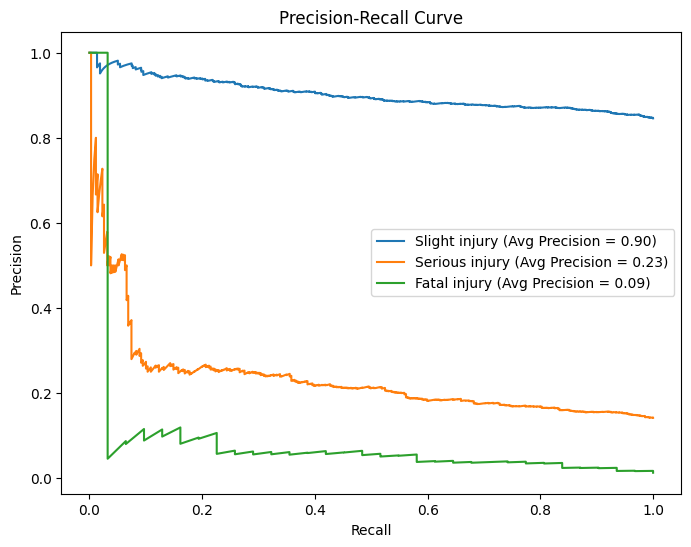

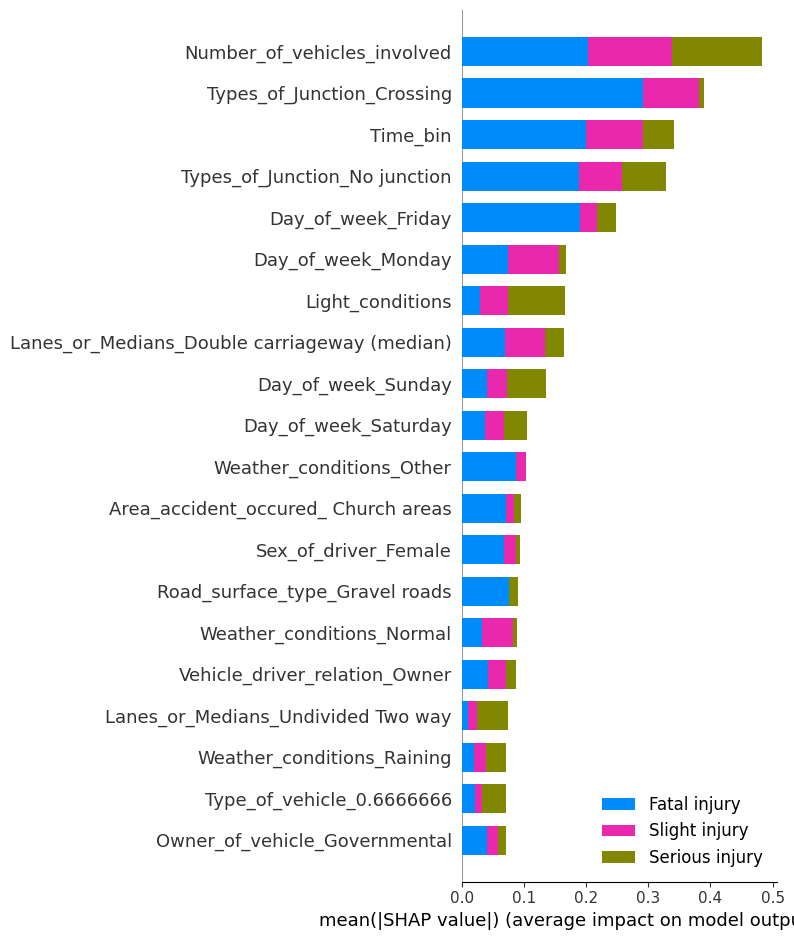

In [ ]:
# model3 = LGBMClassifier
advance_analysis(model3, X_test, y_test)

Confusion Matrix:
[[1316  462  306]
 [ 152  151   46]
 [   6    6   19]]


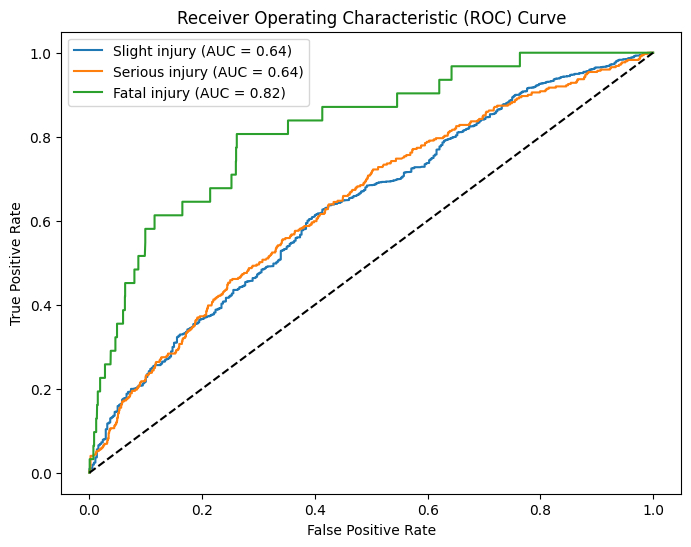

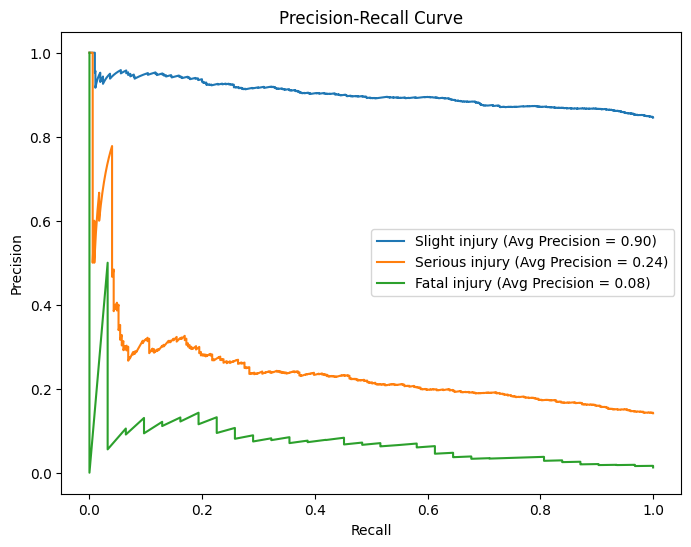

AssertionError: ignored

In [ ]:
# model4 = GradientBoostingClassifier
advance_analysis(model4, X_test, y_test)